In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow import keras
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
print(tf.__version__)
print(sys.version_info)
import h2o
from h2o.automl import H2OAutoML
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2023-05-18 09:53:47.467356: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 09:53:49.643125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)
matplotlib 3.7.1
numpy 1.23.5
pandas 2.0.1
sklearn 1.2.2
tensorflow 2.12.0
keras.api._v2.keras 2.12.0


In [2]:
if os.environ.get('COMPUTERNAME') == 'DESKTOP-EQAO3M5' or os.environ.get('NAME') == 'DESKTOP-EQAO3M5':
  if os.environ.get('WSL_DISTRO_NAME') == 'Ubuntu-20.04':
    computer_flag = 'home_WSL2'
  else:
    computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  root_dir = "F:/github/pythonScript/seafog/"
elif computer_flag == 'home_WSL2':
  root_dir = "/mnt/f/github/pythonScript/seafog/"
else:
  root_dir = "H:/github/python/seafog/"

def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

def reverse_linear_vis(x):
    if(x<0):
      y = 1
    elif(x <= 1.0):
      y = x*1000.0
    elif(x <= 2.0):
      y = (x - 1.0)*9000.0 + 1000.0
    elif(x <= 3.0):
      y = (x-2.0)*20000 + 10000.0
    else:
      y = 30000.0
    return y

def setDataset(df, x_columns):
    df['t_td'] =  df['t2mm'] - df['t2md']
    df['td_sst'] =  df['t2md'] - df['sstk']
    df['t_sst'] =  df['t2mm'] - df['sstk']
    df['delta_theta'] = df['theta925'] - df['theta1000']
    df['delta_theta_e'] = df['theta_e925'] - df['theta_e1000']
    df_x = df.loc[:, x_columns]
    df_y = df['station_vis_linear']
    _x = df_x.to_numpy()
    _y = df_y.to_numpy()
    return (_x, _y)

def getScore(x,y, model):
    predictions = model(x).numpy()
    y_p = predictions[:,0]
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')

def getLevelRatio(df):
    length = len(df)
    ratio_fog = len(df.loc[df['prediction']<=1.0])/length
    ratio_mist = len(df.loc[(df['prediction']>1.0) & (df['prediction']<=2.0)])/length
    ratio_clear = len(df.loc[df['prediction']>2.0])/length
    print(f'比例: 雾:{ratio_fog}, 轻雾{ratio_mist}, 无雾{ratio_clear}')
    return (ratio_fog, ratio_mist, ratio_clear)

def get_fog_TSscore(df, threshold=1.0):
    length = len(df)
    NA = len(df.loc[(df['prediction']<=threshold) & (df['y']<=threshold)]) # 正确数
    NB = len(df.loc[(df['prediction']<=threshold) & (df['y']>threshold)]) # 空报数
    NC = len(df.loc[(df['prediction']>threshold) & (df['y']<=threshold)]) # 空报数
    TS_score = NA/(NA + NB + NC)
    return TS_score

def get_NWP_score(df):
    y = df['station_vis'].apply(linear_vis)
    y_p = df['visi'].apply(linear_vis)
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s.dropna(inplace=True)
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')

In [3]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fullhour/fog_dataset_fulltime.hdf"
# fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fullhour/fog_dataset_72h1_168h6.hdf'))
# fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_allstation.h5'))
# fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_hdf66_fc120h.h5'))
fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_hdf66_fc120h_v2.h5'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')
df_valid_test = store_dataset.get('valid_test')

real_fcHour_list = list(range(0, 72+1, 3)) + list(range(78, 168+1, 6))
df_test_real = df_test.loc[df_test['fc_hour'].isin(real_fcHour_list) ].copy(deep=True)
df_valid_test_real = df_valid_test.loc[df_valid_test['fc_hour'].isin(real_fcHour_list) ].copy(deep=True)

x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e','theta_e925']

(train_x, train_y) = setDataset(df_train, x_columns)
(valid_x, valid_y) = setDataset(df_valid, x_columns)
(test_x,  test_y)  = setDataset(df_test, x_columns)
(valid_test_x, valid_test_y) = setDataset(df_valid_test, x_columns)

(test_real_x,  test_real_y)  = setDataset(df_test_real, x_columns)
(valid_test_real_x, valid_test_real_y) = setDataset(df_valid_test_real, x_columns)



print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.transform(valid_x)
valid_test_x_scaled = scaler.transform(valid_test_x)

test_x_real_scaled  = scaler.transform(test_real_x)
valid_test_x_real_scaled = scaler.transform(valid_test_real_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]
    valid_test_x_scaled[:,index]  = valid_test_x[:,index]

    test_x_real_scaled[:,index]  = test_real_x[:,index]
    valid_test_x_real_scaled[:,index]  = valid_test_real_x[:,index]


['/test', '/train', '/valid', '/valid_test']
(469269, 17)
(469269,)


In [4]:
# 初始化H2O集群
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,12 hours 35 mins
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_minhill_hzrs2p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.228 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [4]:


# 将数据转换为H2O数据框
train = h2o.H2OFrame(train_x_scaled, column_names=x_columns)
train['target'] = h2o.H2OFrame(train_y)
valid = h2o.H2OFrame(valid_x_scaled, column_names=x_columns)
valid['target'] = h2o.H2OFrame(valid_y)
x = train.columns
y = "target"
x.remove(y)
# aml = H2OAutoML(max_models=20, seed=1)
aml = H2OAutoML(max_models=20, seed=1,stopping_rounds=10, stopping_metric='RMSE', stopping_tolerance=0.01, sort_metric='RMSE',nfolds=0)
aml.train(x=x, y=y, training_frame=train, validation_frame=valid)

lb = aml.leaderboard
print(lb)
best_model = aml.leader
test = h2o.H2OFrame(test_x_scaled, column_names=x_columns)
preds = best_model.predict(test)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 58 mins
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_minhill_hzrs2p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.973 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                  rmse       mse       mae     rmsle    mean_residual_deviance
DeepLearning_grid_2_AutoML_3_20230517_231741_model_1  0.463723  0.215039  0.371177  0.254906                  0.215039
DeepLearning_grid_1_AutoML_3_20230517_231741_model_1  0.472178  0.222952  0.373166  0.260366                  0.222952
XGBoost_3_AutoML_3_20230517_231741                    0.47395   0.224628  0.375171  0.256565                  0.224628
GBM_grid_1_AutoML_3_20230517_231741_model_2      

In [7]:
best_model = aml.leader
test = h2o.H2OFrame(test_x_scaled, column_names=x_columns)
preds = best_model.predict(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [5]:
def getScore(x,y, model):
    predictions = model.predict(x)
    y_p = predictions.as_data_frame().values.flatten()
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')

In [6]:
print('#### ==================训练集==========')
getScore(h2o.H2OFrame(train_x_scaled, column_names=x_columns), train_y, best_model)
print('#### ===============验证集==========')
getScore(h2o.H2OFrame(valid_x_scaled, column_names=x_columns), valid_y, best_model)
print('#### ===================测试集==========')
getScore(h2o.H2OFrame(test_x_scaled, column_names=x_columns), test_y, best_model)

#### ==================训练集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.8824917051840202, 轻雾0.11695850354487511, 无雾0.000549791271104633
* 实况为轻雾时: 比例: 雾:0.1295269877191973, 轻雾0.6777392071498437, 无雾0.192733805130959
* 实况为无雾时: 比例: 雾:0.012165730103629261, 轻雾0.2672369152873938, 无雾0.7205973546089769
* TS评分: 雾: 0.7729677972080835, 轻雾及雾: 0.792627141699224
#### ===============验证集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.7932515886512127, 轻雾0.20674841134878724, 无雾0.0
* 实况为轻雾时: 比例: 雾:0.25986753781437394, 轻雾0.7343372415644858, 无雾0.005795220621140249
* 实况为无雾时: 比例: 雾:0.0076971270025955425, 轻雾0.23366598048867807, 无雾0.7586368925087263
* TS评分: 雾: 0.625807590467

In [7]:
# 获取模型的排行榜
lb = aml.leaderboard

# 将排行榜转化为列表
model_ids = lb.as_data_frame()['model_id'].tolist()

# 遍历并保存每个模型
for i, model_id in enumerate(model_ids):
    i_model = h2o.get_model(model_id)
    print(f'#### =========={model_id}=========测试集==========')
    getScore(h2o.H2OFrame(test_x_scaled, column_names=x_columns), test_y, i_model)


#### ==========DeepLearning_grid_2_AutoML_3_20230517_231741_model_1=========测试集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.6501018056518918, 轻雾0.34537847090148344, 无雾0.004519723446624751
* 实况为轻雾时: 比例: 雾:0.2600407222607567, 轻雾0.7344774349450697, 无雾0.005481842794173584
* 实况为无雾时: 比例: 雾:0.007450831226366545, 轻雾0.23001364866981405, 无雾0.7625355201038194
* TS评分: 雾: 0.5129042508120322, 轻雾及雾: 0.8893988939889399
#### ==========DeepLearning_grid_1_AutoML_3_20230517_231741_model_1=========测试集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.6669948314053655, 轻雾0.3321549235898239, 无雾0.0008502450048105967
* 实况为轻雾时: 比例: 雾:0.2842727048978587, 轻雾0.6857673461168415, 无

In [8]:
# 保存模型
model_dir = os.path.normpath(os.path.join(root_dir, './src/h2o/h2o_model_v3_best'))
best_model = h2o.get_model('DeepLearning_grid_1_AutoML_3_20230517_231741_model_1')
model_path = h2o.save_model(model=best_model, path=model_dir, force=True)


In [9]:
# 获取模型的排行榜
lb = aml.leaderboard

# 将排行榜转化为列表
model_ids = lb.as_data_frame()['model_id'].tolist()

# 遍历并保存每个模型
for i, model_id in enumerate(model_ids):
    model = h2o.get_model(model_id)
    model_dir = os.path.normpath(os.path.join(root_dir, f'./src/h2o/all_model_v3/model_{i}'))
    h2o.save_model(model=model, path=model_dir, force=True)


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

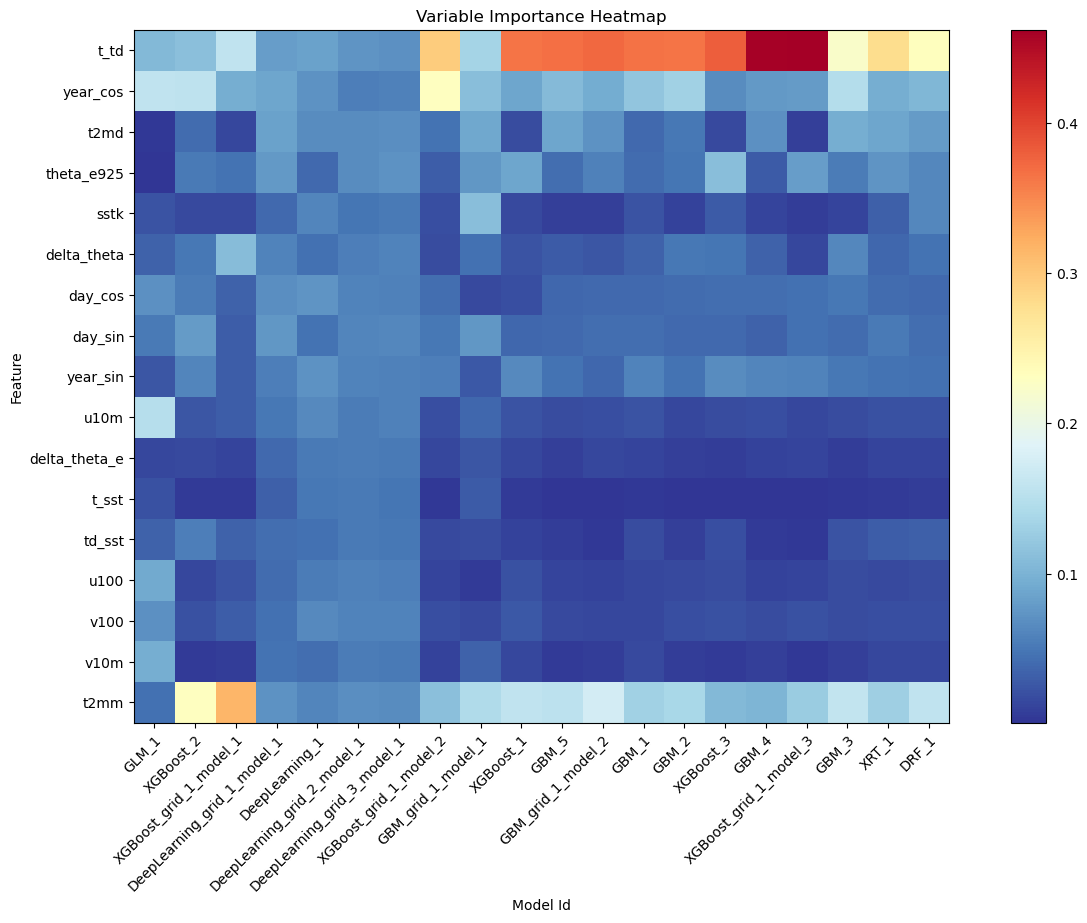

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

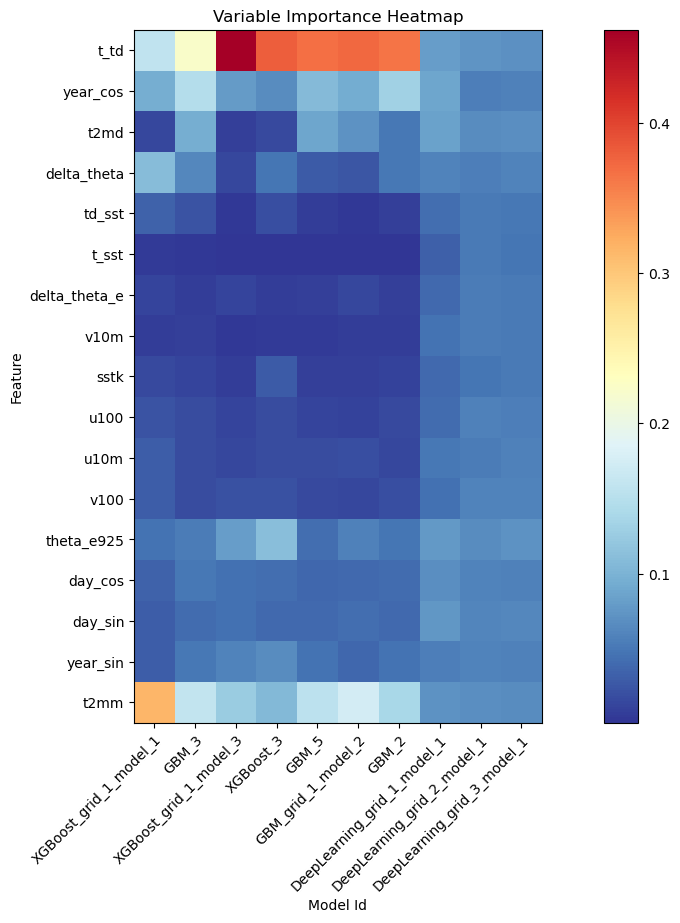

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

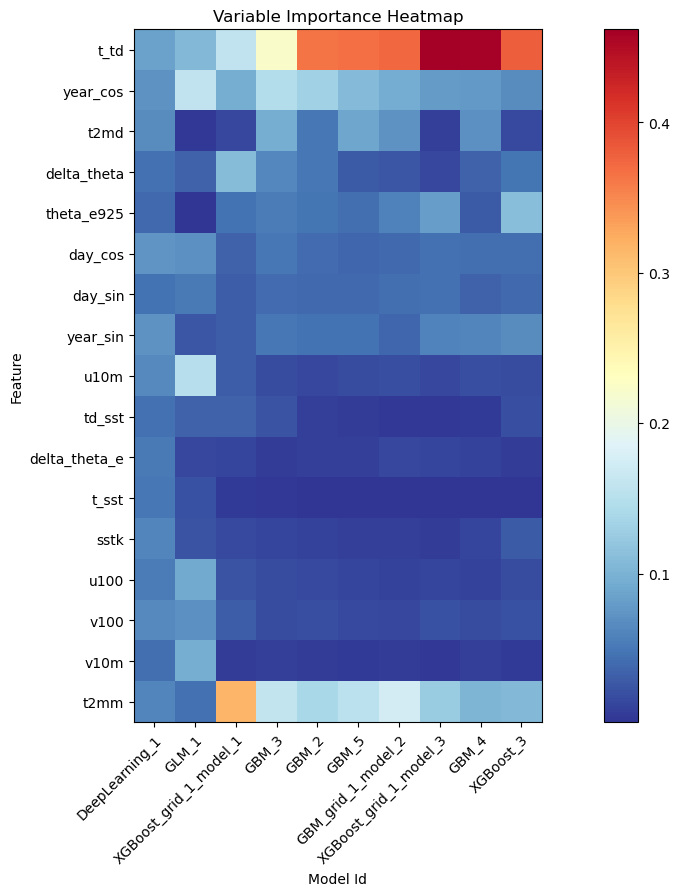

In [16]:
va_plot = aml.varimp_heatmap()

# 或者如果需要一些模型的子集，就可以使用积分排行榜的一部分，
# 例如，使用MAE作为排序指标
va_plot = h2o.varimp_heatmap(aml.leaderboard.sort("mae").head(10))

# 甚至可以使用扩展排行榜
va_plot = h2o.varimp_heatmap(
   h2o.automl.get_leaderboard(
        aml,extra_columns="training_time_ms"
    ).sort("training_time_ms").head(10))


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

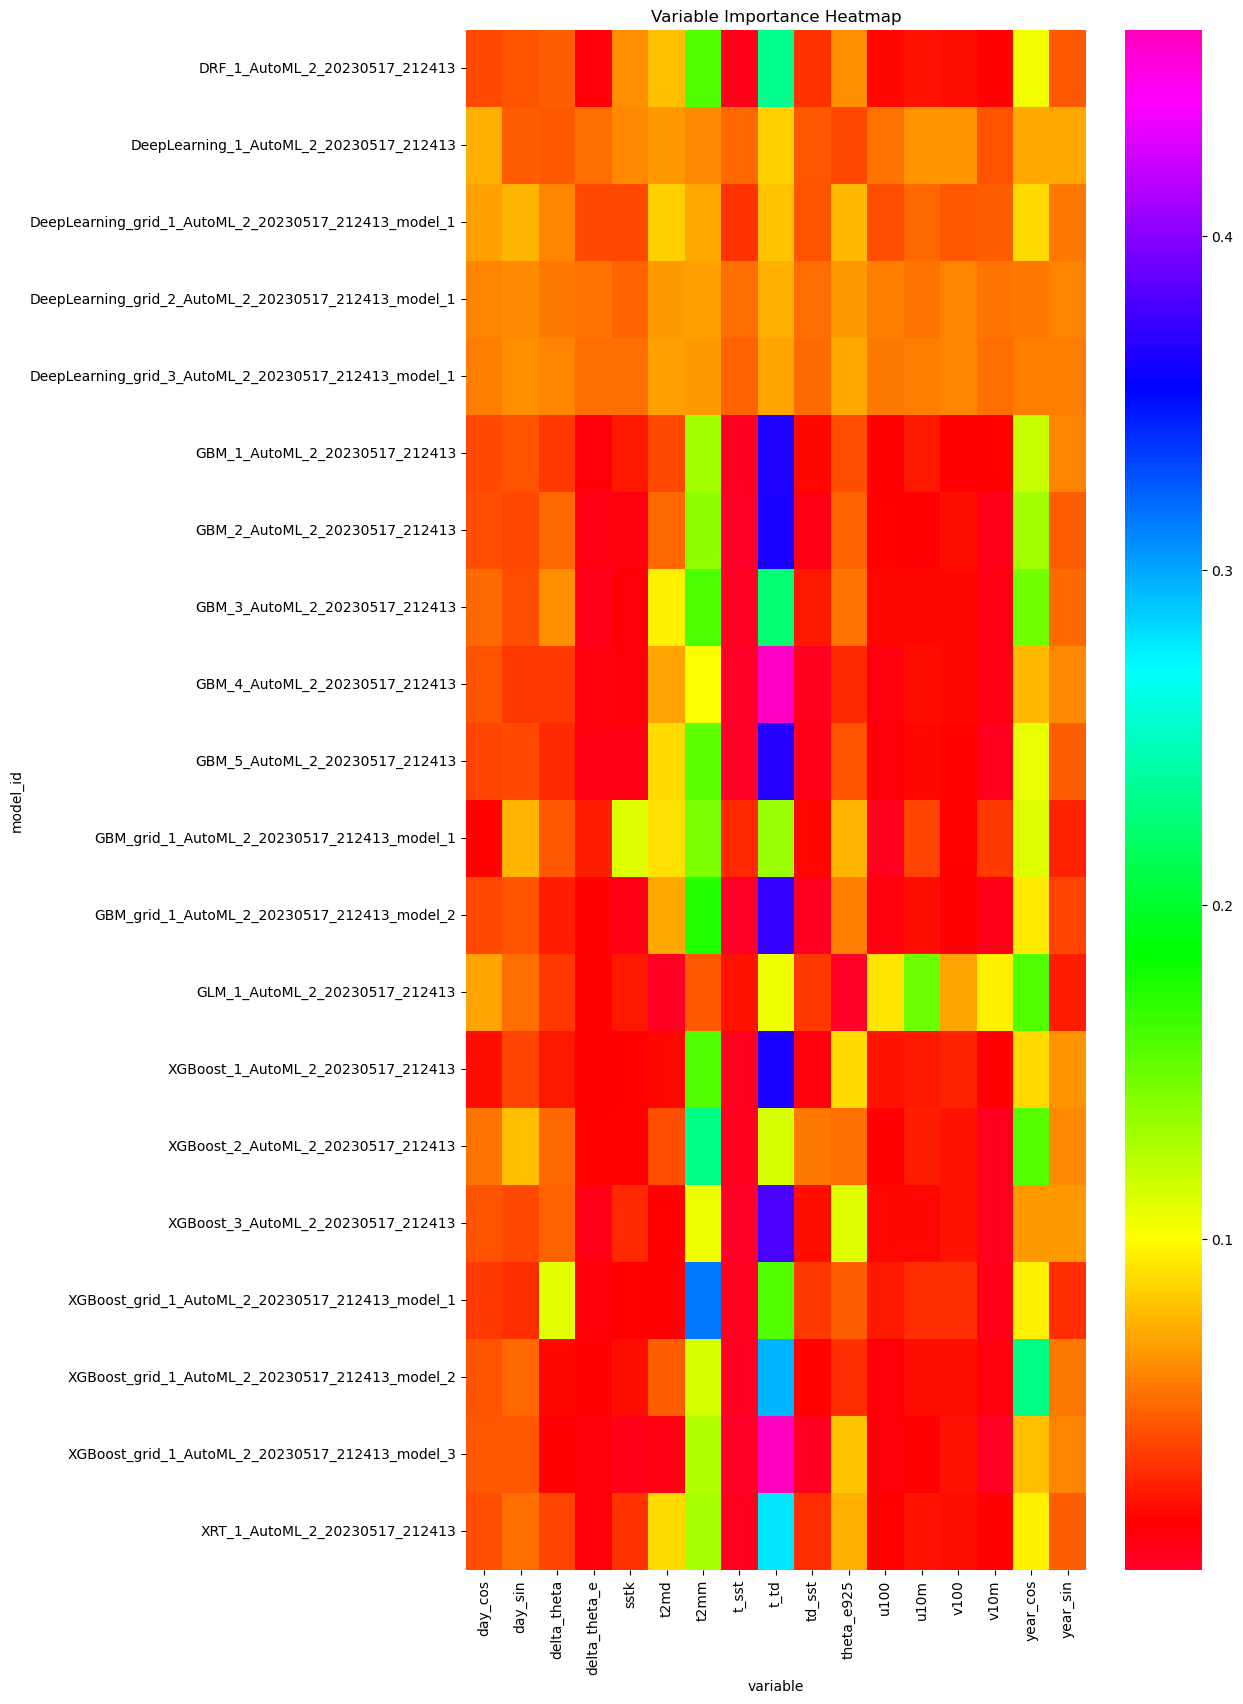

In [20]:
# 导入所需库
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 获取模型的排行榜
lb = aml.leaderboard

# 将排行榜转化为列表
model_ids = lb.as_data_frame()['model_id'].tolist()

# 提取每个模型的变量重要性
varimps = []
for model_id in model_ids:
    model = h2o.get_model(model_id)
    try:
        varimp = model.varimp(use_pandas=True)
        varimp['model_id'] = model_id
        varimps.append(varimp)
    except Exception:
        continue  # 如果模型不提供变量重要性，跳过该模型
    

# 如果没有任何模型提供变量重要性，停止
if not varimps:
    raise ValueError("No models with variable importance")

# 将变量重要性合并为一个DataFrame
varimp_df = pd.concat(varimps, axis=0)

# 对变量重要性进行归一化处理
varimp_df['scaled_importance'] = varimp_df.groupby('model_id')['scaled_importance'].transform(lambda x: x / x.sum())

# 创建变量重要性热力图
plt.figure(figsize=(10, len(varimps)))
sns.heatmap(data=varimp_df.pivot(index='model_id', columns='variable', values='scaled_importance'), cmap='gist_rainbow')
plt.title('Variable Importance Heatmap')
plt.show()


In [10]:
best_model = h2o.get_model('DeepLearning_grid_1_AutoML_3_20230517_231741_model_1')
print('#### ==================训练集==========')
getScore(h2o.H2OFrame(train_x_scaled, column_names=x_columns), train_y, best_model)
print('#### ===============验证集==========')
getScore(h2o.H2OFrame(valid_x_scaled, column_names=x_columns), valid_y, best_model)
print('#### ===================测试集-预报==========')
getScore(h2o.H2OFrame(test_x_scaled, column_names=x_columns), test_y, best_model)
print('#### ===================测试集+验证==========')
getScore(h2o.H2OFrame(valid_test_x_scaled, column_names=x_columns), valid_test_y, best_model)

#### ==================训练集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.8447670738957825, 轻雾0.15431873829296203, 无雾0.0009141878112553781
* 实况为轻雾时: 比例: 雾:0.13095260927101512, 轻雾0.6568982822219239, 无雾0.21214910850706098
* 实况为无雾时: 比例: 雾:0.012817808122846384, 轻雾0.26509528649878855, 无雾0.7220869053783651
* TS评分: 雾: 0.7385809783580755, 轻雾及雾: 0.7844621938829922
#### ===============验证集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.8056027924460754, 轻雾0.19439720755392464, 无雾0.0
* 实况为轻雾时: 比例: 雾:0.28414481338942094, 轻雾0.684731048062293, 无雾0.031124138548286048
* 实况为无雾时: 比例: 雾:0.00792088069453146, 轻雾0.2340687371341627, 无雾0.7580103821713058
* TS评分: 雾: 0.6234998701

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

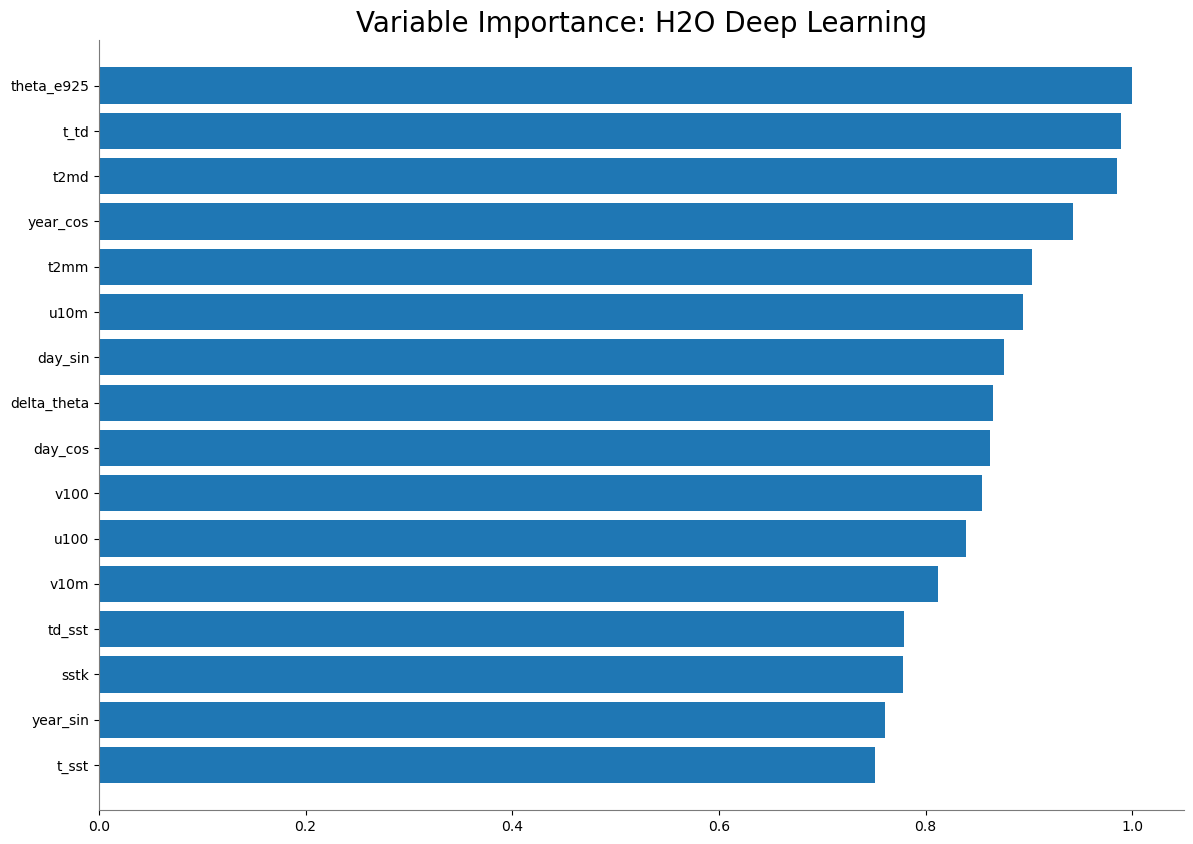

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_3_20230517_231741_model_1


Status of Neuron Layers: predicting target, regression, gaussian distribution, Quadratic loss, 1,901 weights/biases, 29.0 KB, 51,607,903 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight             weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  ----------------------  -------------------  -------------------  -----------------------
    1        17       Input             15.0
    2        100      RectifierDropout  10.0       0.0   0.0   0.007214939944439239   0.02488706260919571    0.0         -0.0005389498452709899  0.13952189683914185  0.27912636121447953  0.11471480131149292
    3        1        Linear                       0.0   0.0   0.0003213396303181071  9.322483674623072e-05  0.0         0.010499248161795548    0.07709953188896179  -0.04360540872766    1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.20278530113845347
RMSE: 0.4503168896881989
MAE: 0.3489165655236178
RMSLE: 0.20626465871385716
Mean Residual Deviance: 0.20278530113845347

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.22295191514166704
RMSE: 0.47217784270512636
MAE: 0.37316616124962415
RMSLE: 0.26036620720178355
Mean Residual Deviance: 0.22295191514166704

Scoring History: 
     timestamp            duration          training_speed    epochs               iterations    samples     training_rmse        training_deviance    training_mae         training_r2         validation_rmse      validation_deviance    validation_mae       validation_r2
---  -------------------  ----------------  ----------------  -------------------  ------------  ----------  -------------------  -------------------  -------------------  ------------------  -------------------  ---------------------  -------------------  ------------------
     2023-05-17 23:25:43  0.000 sec                           0.0                  0             0.0         nan                  nan                  nan                  nan                 nan                  nan                    nan                  nan
     2023-05-17 23:25:44  0.555 sec         230327 obs/sec    0.21301641489209813  1             99962.0     0.4503168896881989   0.20278530113845347  0.3489165655236178   0.7168088724437972  0.47217784270512636  0.22295191514166704    0.37316616124962415  0.7395383739511685
     2023-05-17 23:25:49  5.809 sec         302836 obs/sec    3.621626401914467    17            1699517.0   0.40417826303115406  0.16336006830688074  0.311502212287463    0.7718664928781106  0.48209801927573176  0.23241850018958382    0.38527292696650295  0.7284791187160511
     2023-05-17 23:25:54  10.995 sec        381997 obs/sec    8.737758087578767    41            4100359.0   0.4064889750097948   0.1652332868045136   0.3080105972623598   0.7692505298101484  0.4730532991092409   0.22377942379813692    0.37381483495123385  0.7385716441964738
     2023-05-17 23:25:59  16.117 sec        430562 obs/sec    14.489420779979074   68            6799436.0   0.38681213784569024  0.1496236299847533   0.29550465449069296  0.7910495275221924  0.49431436385461525  0.24434669031299297    0.39149542642908264  0.7145441148682993
     2023-05-17 23:26:04  21.248 sec        460593 obs/sec    20.45472213165583    96            9598767.0   0.3813327663472348   0.14541467869003474  0.29284067912848805  0.7969273581947749  0.5143707207813845   0.26457723839716096    0.4043762620548457   0.6909099539035313
     2023-05-17 23:26:09  26.381 sec        478525 obs/sec    26.422075611216595   124           12399061.0  0.3797228158091792   0.14418941684605185  0.28832747157494343  0.798638

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

<Figure size 640x480 with 0 Axes>

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

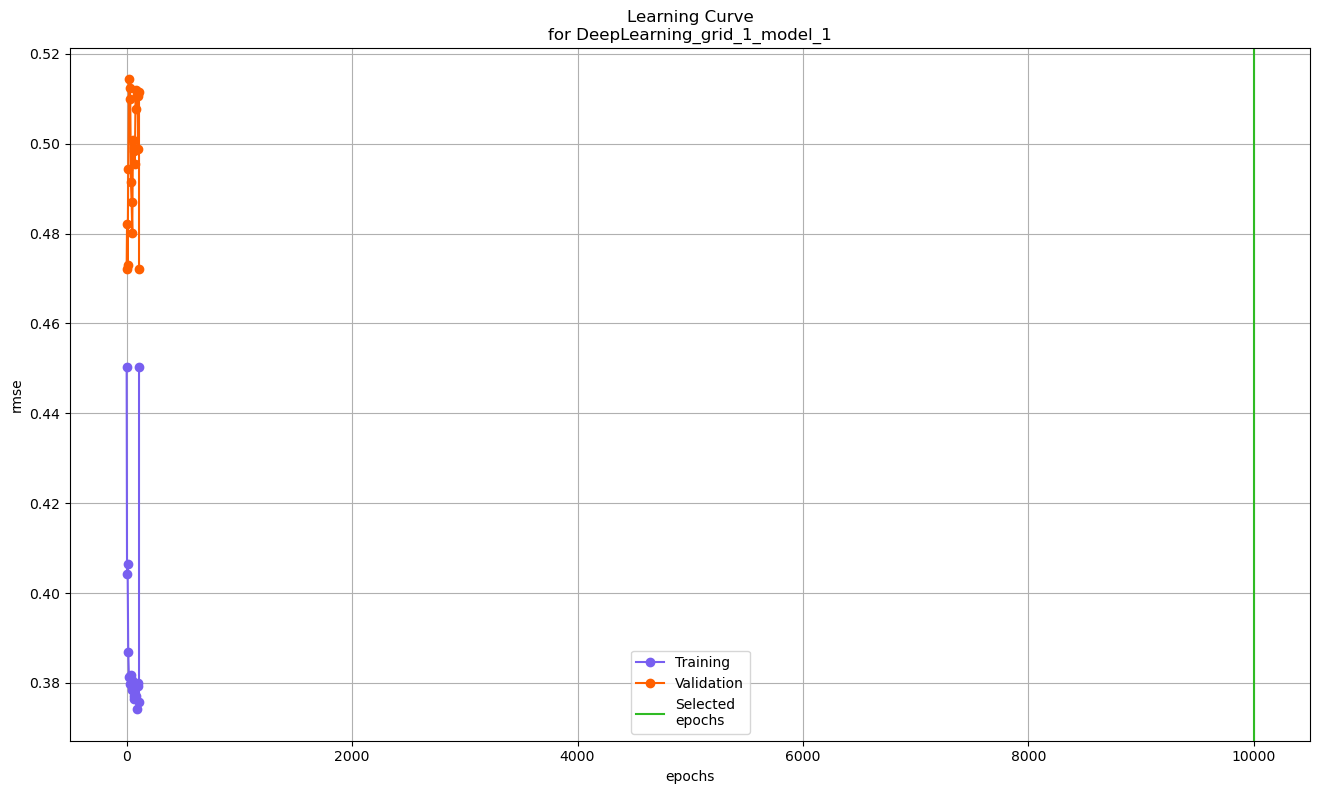

In [12]:
model = h2o.get_model('DeepLearning_grid_1_AutoML_3_20230517_231741_model_1')
ra_plot = model.varimp_plot(num_of_features=-1)
learning_curve_plot = model.learning_curve_plot()

# build the hit ratio table:
model.show()


In [15]:
model.gains_lift_plot()

AttributeError: type object 'ModelBase' has no attribute 'gains_lift_plot'

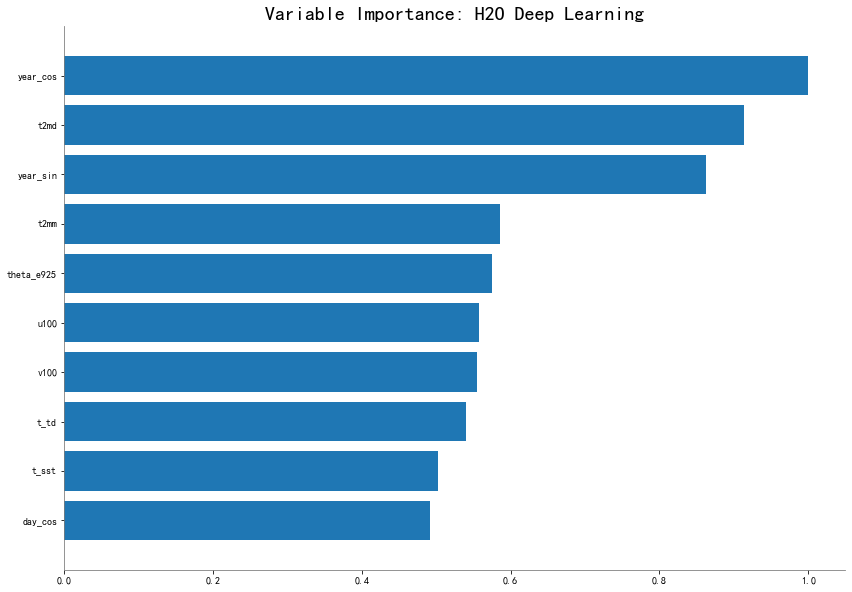

<Figure size 432x288 with 0 Axes>

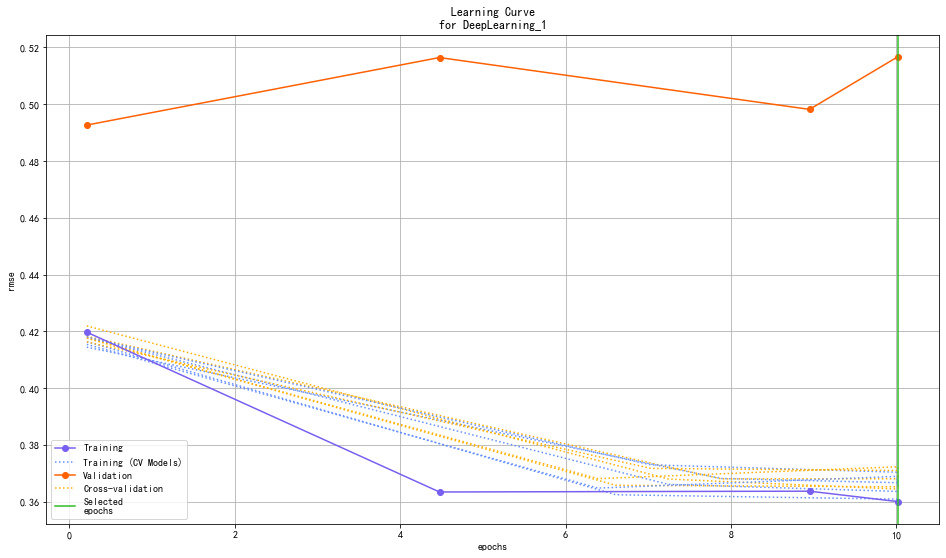

In [35]:


model = h2o.get_model("DeepLearning_1_AutoML_2_20230517_23608")
ra_plot = model.varimp_plot()
learning_curve_plot = model.learning_curve_plot()

In [7]:
model = h2o.load_model("/mnt/f/github/pythonScript/seafog/src/h2o/h2o_model_v3_best/DeepLearning_grid_1_AutoML_3_20230517_231741_model_1")

# Print the model summary
print(model.summary())

Status of Neuron Layers: predicting target, regression, gaussian distribution, Quadratic loss, 1,901 weights/biases, 29.0 KB, 51,607,903 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight             weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  ----------------------  -------------------  -------------------  -----------------------
    1        17       Input             15.0
    2        100      RectifierDropout  10.0       0.0   0.0   0.007214939944439239   0.02488706260919571    0.0         -0.0005389498452709899  0.13952189683914185  0.27912636121447953  0.11471480131149292
    3        1        Linear                       0.0   0.0   0.0003213396303181071  9.322483674623072e-05  0.0         0.010499248161795548    0.07709953188896179  -0

layer	units	type	dropout	l1	l2	mean_rate	rate_rms	momentum	mean_weight	weight_rms	mean_bias	bias_rms
	1	17	Input	15.0									
	2	100	RectifierDropout	10.0	0	0	0.0072	0.0249	0	-0.0005	0.1395	0.2791	0.1147
	3	1	Linear		0	0	0.0003	0.0001	0	0.0105	0.0771	-0.0436	0.0
  